# Loop Example 1

> * High level approach to making a 3D model from just a bounding box and source files as input. (In Australia only for now. Documentation to come)
> * To run this notebook, please download and unzip the Turner Syncline data folder (https://github.com/Loop3D/Turner_Syncline/) into where this notebook is running.

In [1]:
import time
t0 = time.time()

## Map2Loop

In [1]:
import os
from map2loop.project import Project

proj = Project( 
#                  geology_file="Turner_Syncline/tmp/geol_clip.shp",
#                  fault_file="Turner_Syncline/tmp/GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.csv",
#                  fold_file="Turner_Syncline/tmp/GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.csv",
#                  structure_file="Turner_Syncline/tmp/structure_clip.shp",
#                  mindep_file="Turner_Syncline/tmp/mindeps_clip.shp",
#                  metadata=os.path.abspath("Turner_Syncline/meta.hjson")
                 state = "WA",
                 remote = True,
                 # path to hosted metadata describing the remote sources
                 metadata='https://gist.githubusercontent.com/yohanderose/8f843de0dde531f009a3973cbdadcc9f/raw/918f412ae488ce1a6bca188306f7730061ecf551/meta_remote.hjson'
                )

proj.update_config(
                    out_dir='./model-test',
                    overwrite='true',
                    bbox_3d={
                         "minx": 500000,
                         "miny": 7490000,
                         "maxx": 545000,
                         "maxy": 7520000,
                         "base": -3200,
                         "top": 1200,
                     },
                    proj_crs={'init': 'EPSG:28350'},
                    quiet=True
                  )

In [2]:
proj.run()

100%|████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.98it/s]

No StratigraphicInformation present on access request

This is a valid Loop Project File


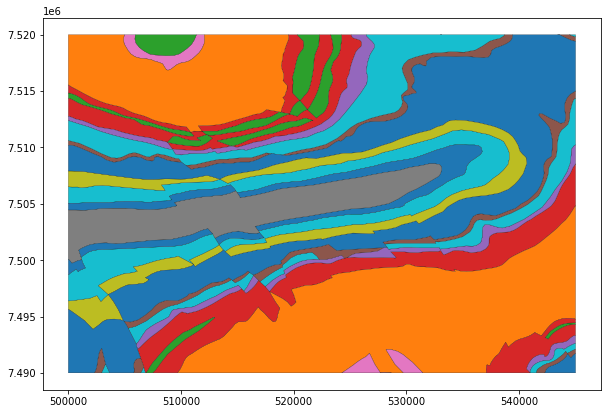

In [3]:

proj.config.geology_figure

## Loop Structural

In [4]:
import fiona

In [5]:
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [ ]:
# Define project pathing from m2l
proj_path = proj.config.project_path
graph_path = proj.config.graph_path
tmp_path = proj.config.tmp_path
data_path = proj.config.data_path
dtm_path = proj.config.dtm_path
output_path = proj.config.output_path
vtk_path = proj.config.vtk_path

# Define project bounds
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']

fault_file = proj.config.fault_file_csv

In [ ]:
import random
import os
import time
from datetime import datetime
import shutil
import logging
logging.getLogger().setLevel(logging.ERROR)

import numpy as np
from LoopStructural import GeologicalModel
import lavavu
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural import GeologicalModel

nowtime=datetime.now().isoformat(timespec='minutes')   
model_name='leaflet'+'_'+nowtime.replace(":","-").replace("T","-")
if (os.path.exists(vtk_path+model_name)):
    shutil.rmtree(vtk_path+model_name)
os.mkdir(vtk_path+model_name)
filename=vtk_path+model_name+'/'+'surface_name_{}.vtk'


f=open(tmp_path+'bbox.csv','w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()
t1 = time.time()
fault_params = {'interpolatortype':'FDI',
                'nelements':3e4,
                'data_region':.1,
                'solver':'pyamg',
#                 overprints:overprints,
                'cpw':10,
                'npw':10}
foliation_params = {'interpolatortype':'PLI' , # 'interpolatortype':'PLI',
                    'nelements':1e5,  # how many tetras/voxels
                    'buffer':0.8,  # how much to extend nterpolation around box
                    'solver':'pyamg',
                    'damp':True}

if(not os.path.exists(fault_file)):
    f=open(output_path + '/fault_displacements3.csv','w')
    f.write('X,Y,fname,apparent_displacement,vertical_displacement,downthrow_dir\n')
    f.close()
    f=open(output_path + '/fault_orientations.csv','w')
    f.write('X,Y,Z,DipDirection,dip,DipPolarity,formation\n')
    f.close()
    f=open(output_path + '/faults.csv','w')
    f.write('X,Y,Z,formation\n')
    f.close()
    f=open(output_path + '/fault-fault-relationships.csv','w')
    f.write('fault_id\n')
    f.close()
    f=open(output_path + '/group-fault-relationships.csv','w')
    f.write('group\n')
    f.close()

    model, m2l_data = GeologicalModel.from_map2loop_directory(proj_path,
                                                          skip_faults=True,
                                                          fault_params=fault_params,
                                                          foliation_params=foliation_params)
else:
    model, m2l_data = GeologicalModel.from_map2loop_directory(proj_path,
                                                          skip_faults=False,
                                                          fault_params=fault_params,
                                                          foliation_params=foliation_params)

view = LavaVuModelViewer(model,vertical_exaggeration=1) 
view.nsteps = np.array([200,200,200])
#view.set_zscale(2)
view.add_model(cmap='tab20')
view.nsteps=np.array([50,50,50])
#view.add_model_surfaces(filename=filename)
view.add_model_surfaces()
for sg in model.feature_name_index:
    if( 'super' in sg):
        view.add_data(model.features[model.feature_name_index[sg]])
view.interactive()  

for sg in model.feature_name_index:
    if( 'super' in sg):
        view.add_data(model.features[model.feature_name_index[sg]])

t2 = time.time()
print("m2l",(t1-t0)/60.0,"LoopStructural",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")